## Plot results of training of a SVDTime Neural Network

This notebook displays the results of time fits for digit produced by the SVD digitizer.
The digits are collected using the SVDFitDigitsModule, and its output is imported and shown here. 

##### Required Python packages

The following python packages are used:
- math (basic python math functions)
- numpy (Vectors and matrices for numerics)
- pandas (Python analogue of Excel tables)
- matplotlib (Plotting library)
- seaborn (Advanced plotting)
- scipy (Scientific computing package)
- scikit-learn (machine learning)

If you get an error message complaining about a missing package, do

pip3 install *_package name_*

##### Other pre-requisites:

A sample of training data, plus binning and bounds information in pickle (*.pkl) files.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats as stats
from scipy.optimize import minimize_scalar
from svd.SVDSimBase import *

Welcome to JupyROOT 6.08/06


### Retrieve dumped digit fits

In [2]:
digit_fit_filename = '/media/sf_MateShare/kvasnicka/tb2017/output/dumped_tb_digits.txt'

digits = pd.read_csv(digit_fit_filename, index_col = False, delim_whitespace = True)

pkl_name = 'SVDTime_TrainingBins_1000000.pkl'
bins = pd.read_pickle(pkl_name)

timearray = bins['midpoint']
timebins = np.unique(bins[['lower','upper']])

In [3]:
digits.head()

,EventNo,Layer,Ladder,Sensor,Side,StripNo,TimeTrigger,GoodStrip,Gain,Noise,...,TimeShift,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Charge,TimeFit,Chi2
0,14,3,1,2,u,287,-11.79,y,328.413,1051.319,...,96.414,3.0,16.0,40.0,42.0,36.0,27.0,16246.468,-24.204,1.538
1,14,3,1,2,u,288,-11.79,y,328.020,1066.836,...,92.989,0.0,13.0,33.0,34.0,23.0,16.0,12151.880,-26.941,1.382
2,14,3,1,2,u,375,-11.79,y,308.901,1132.497,...,92.205,1.0,42.0,109.0,109.0,86.0,63.0,41406.969,-26.044,4.008
3,14,3,1,2,u,397,-11.79,y,317.472,964.853,...,93.986,0.0,15.0,40.0,41.0,28.0,25.0,15118.291,-25.229,1.578
4,14,3,1,2,u,439,-11.79,y,317.114,1038.880,...,94.985,6.0,14.0,33.0,34.0,30.0,20.0,13214.970,-25.026,1.198


We add a random column for sampling. We set the value to negative for rows we want to exclude from sampling. First thhing we exclude bad strips from consideration.

Index(['EventNo', 'Layer', 'Ladder', 'Sensor', 'Side', 'StripNo',
       'TimeTrigger', 'GoodStrip', 'Gain', 'Noise', 'Width', 'TimeShift',
       'Sample0', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5',
       'Charge', 'TimeFit', 'Chi2', 'Test'],
      dtype='object')

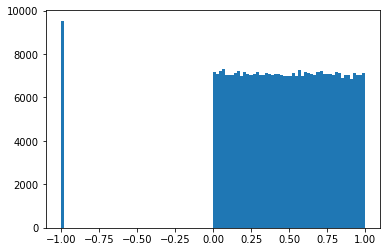

In [4]:
digits['Test'] = np.random.uniform(0.0,1.0,len(digits))
digits['Test'] = digits.apply(lambda row: row.Test if row.GoodStrip == 'y' else -1, axis = 1)
plt.hist(digits.Test, bins = 100);
digits.columns

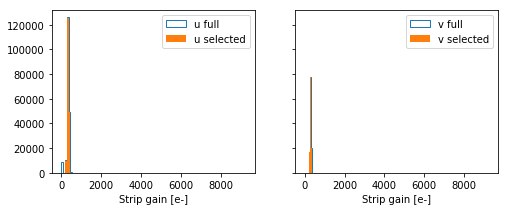

In [5]:
gain_low = 250
gain_high = 500
digits.Test = digits.apply(lambda row: row.Test if (row.Gain > gain_low and row.Gain < gain_high) else -1.0, axis = 1)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Gain[digits.Side==side], histtype = 'step', bins = 100, label = side + ' full');
    ax[i].hist(digits.Gain[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Strip gain [e-]')
plt.savefig('Gain_selection.png')

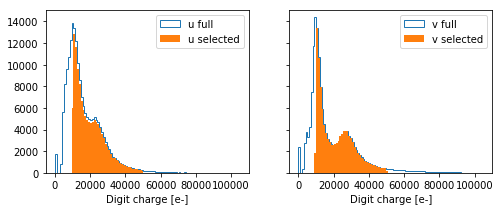

In [6]:
amplitude_low = 10000
amplitude_high = 50000
digits.Test = digits.apply(lambda row: row.Test if (row.Charge > amplitude_low and row.Charge < amplitude_high) else -1.0, axis = 1)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Charge[digits.Side==side], histtype = 'step', bins = 100, label = side + ' full');
    ax[i].hist(digits.Charge[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Digit charge [e-]')
plt.savefig('Amplitude_selection.png')

Now we also exclude data with extremely bad fits.

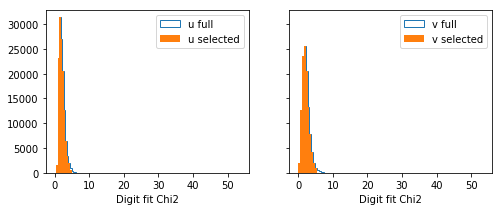

In [7]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(digits.Chi2[np.logical_and(digits.Side==side, digits.Test > 0.0)], histtype = 'step', bins = 100, label = side + ' full');
    max_chi2 = np.percentile(digits.Chi2[np.logical_and(digits.Side==side, digits.Test>0.0)], [99])[0]
    digits.Test = digits.apply(lambda row: row.Test if row.Side != side or row.Chi2 < max_chi2 else -1.0, axis = 1)
    ax[i].hist(digits.Chi2[np.logical_and(digits.Side==side, digits.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Digit fit Chi2')
plt.savefig('Chi2_selection.png')

Load the classifier

In [8]:
import pickle
with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
# the sample size of the network we want to use
n_samples = 1000000
pkl_name = 'SVDTime_Training{0}_{1}.pkl'

bounds = pd.read_pickle(pkl_name.format('Bounds', n_samples))

amp_range = (
    bounds.loc[bounds.value == 'amplitude','low'].values[0],
    bounds.loc[bounds.value == 'amplitude','high'].values[0]
)
tau_range =(
    bounds.loc[bounds.value == 'tau','low'].values[0],
    bounds.loc[bounds.value == 'tau','high'].values[0]
)
coder = tau_encoder(amp_range, tau_range)


Function to calculate amplitude, time and chi2 from samples and pdf

In [9]:
def fitFromProb(fw, signals, p, tau, timearray):
    t_fit = np.average(timearray, weights = p)
    t_sigma = np.sqrt(np.average((timearray - t_fit)**2, weights = p))
    weights = fw(-t_fit + np.linspace(-dt, 4*dt, 6, endpoint = True), tau = tau)
    weights[signals == 0.0] = 0.0
    norm = 1.0 / np.inner(weights, weights)
    a_fit = np.inner(signals, weights) * norm
    a_sigma = np.sqrt(norm)
    residuals = signals - a_fit * weights
    ndf = np.sum(np.ones_like(signals[signals>0])) - 2 # Can't be less than 1
    chi2_ndf = np.inner(residuals, residuals)/ndf
    return pd.Series({
        't_fit':t_fit, 
        't_sigma':t_sigma, 
        'a_fit':a_fit, 
        'a_sigma':a_sigma,
        'chi2_ndf':chi2_ndf
            })

### Try to optimize widths using fit chi2.

Find addition to width that minimizes the mean fit chi2.

In [ ]:
dtau_range = (0,50)
sample_size = 1000

def row_chi2(row, dtau = 0.0):
    x = np.zeros(7)
    x[0:6] = row[['Sample{0}'.format(i) for i in range(6)]]
    noise_adu = row.Noise/row.Gain if row.Gain > 0 else 1.0
    x[0:6] = x[0:6]/noise_adu
    tau = row.Width + dtau
    x[6] = coder.encode(tau)
    p = classifier.predict_proba(x.reshape(1,-1))
    fit_result = fitFromProb(betaprime_wave, x[0:6], p[0], tau, timearray)
    #print('Row_chi2: dtau = {0:.3f}, tau = {1:.3f}, chi2 = {2:.3f}'.format(dtau, tau, fit_result['chi2_ndf']))
    return fit_result['chi2_ndf']

def mean_chi2(outside_dtau, data = digits):
    chis = data.apply(row_chi2, dtau = outside_dtau, axis =1)
    mean_chi = np.mean(chis)
    print('Current dtau: {0:.3f}, mean chi2: {1:.3f}'.format(outside_dtau, mean_chi))
    return(mean_chi)

# Things for plotting
dw_values = np.linspace(0.0,30.0,20, endpoint = True) 
chi2_train_values = np.zeros([2,len(dw_values)])
chi2_test_values = np.zeros([2,len(dw_values)])

for side in ['u', 'v']:
    sample_train = digits[np.logical_and(digits.Side == side, digits.Test > 0.0)].sample(n=sample_size)
    sample_test = digits[np.logical_and(digits.Side == side, digits.Test > 0.0)].sample(n=sample_size)
    chi2_init_train = mean_chi2(0.0, data = sample_train)
    chi2_init_test = mean_chi2(0.0, data = sample_test)
    chi2_data_train = np.mean(sample_train.Chi2)
    chi2_data_test = np.mean(sample_test.Chi2)
    print('Side: {0}\nTrain chi2: data {1:.3f}, refit {2:.3f}\nTest chi2: data {3:.3f} refit {4:.3f}'.format(side, chi2_data_train, chi2_init_train, chi2_data_test, chi2_init_test))
    res = minimize_scalar(mean_chi2, method = 'bounded', bounds = dtau_range, args = sample_train, tol = 1.0e-4)
    chi2_final_train = mean_chi2(res.x, data = sample_train)
    chi2_final_test = mean_chi2(res.x, data = sample_test)
    print('Side: {0}\nTrain chi2: initial {1:.3f}, final {2:.3f}\nTest chi2 : initial {3:.3f}, final {4:.3f}\nShift: {5:.3f}'.format(side, chi2_init_train, chi2_final_train, chi2_init_test, chi2_final_test, res.x))
    for i, dw in zip(range(len(dw_values)), dw_values):
        irow = 0 if side == 'u' else 1
        chi2_train_values[irow, i] = mean_chi2(dw, data = sample_train)
        chi2_test_values[irow, i] = mean_chi2(dw, data = sample_test)

In [ ]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = False, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].plot(dw_values, chi2_train_values[i,:], label = side + ' train');
    ax[i].plot(dw_values, chi2_test_values[i,:], label = side + ' test');
    ax[i].legend()
    ax[i].set_xlabel('Width increment [ns]')
    ax[i].set_ylabel('chi2 of fit [ns]')
plt.savefig('Chi2_vs_dw.png')

###  Match distribution of times

Another idea is to start matching time distributions. 
Next, match the distribution to the interval -31.44 to 0
Next, estimate event time.
And last, adjust widths by adjusting time distribution.

In [16]:
dtau_range = (0,50)
sample_size = 1000

def row_t(row, dtau = 0.0):
    x = np.zeros(7)
    x[0:6] = row[['Sample{0}'.format(i) for i in range(6)]]
    noise_adu = row.Noise/row.Gain if row.Gain > 0 else 1.0
    x[0:6] = x[0:6]/noise_adu
    tau = row.Width + dtau
    x[6] = coder.encode(tau)
    p = classifier.predict_proba(x.reshape(1,-1))
    fit_result = fitFromProb(betaprime_wave, x[0:6], p[0], tau, timearray)
    return fit_result['t_fit']

def std_t(group, dtau = 0.0):
    ts = group.apply(row_t, dtau = dtau, axis =1)
    mad_ts = np.std(ts)
    return(mad_ts)

def mean_std_t(outside_tau, data = digits):
    madts = data.apply(std_t, dtau = outside_tau)
    mean_madt = np.mean(madts)
    print('Current dtau: {0:.3f}, mean mad t: {1:.3f}'.format(outside_tau, mean_madt))
    return(mean_madt)

# The procedure is:
# 1. Group by EventNo
# 2. Sample
# 3. For each group:
# 4. Re-fit with new width
# 5. Calculate mean spread of times
# 6. Calculate mean spread of times for whole sample. 

# Things for plotting
dw_values = np.linspace(0.0,30.0,20, endpoint = True) 
dt_train_values = np.zeros([2,len(dw_values)])
dt_test_values = np.zeros([2,len(dw_values)])

for side in ['u', 'v']:
    sample_train = digits[digits.EventNo < sample_size][np.logical_and(digits.Side == side, digits.Test > 0.0)].groupby(digits.EventNo)
    sample_test = digits[np.logical_and(digits.EventNo > sample_size, digits.EventNo < 2*sample_size)][np.logical_and(digits.Side == side, digits.Test > 0.0)].groupby(digits.EventNo)
    stdt_init_train = mean_std_t(0.0, data = sample_train)
    stdt_init_test = mean_std_t(0.0, data = sample_test)
    print('Side: {0}\nTrain std(t) refit {1:.3f}\nTest std(t) refit {2:.3f}'.format(side, stdt_init_train, stdt_init_test))
    res = minimize_scalar(mean_std_t, method = 'bounded', bounds = dtau_range, args = sample_train, options = {'xatol': 1.0e-2})
    stdt_final_train = mean_std_t(res.x, data = sample_train)
    stdt_final_test = mean_std_t(res.x, data = sample_test)
    print('Side: {0}\nTrain std(t): initial {1:.3f}, final {2:.3f}\nTest std(t): initial {3:.3f}, final {4:.3f}\nShift: {5:.3f}'.format(side, stdt_init_train, stdt_final_train, stdt_init_test, stdt_final_test, res.x))
    for i, dw in zip(range(len(dw_values)), dw_values):
        irow = 0 if side == 'u' else 1
        dt_train_values[irow, i] = mean_std_t(dw, data = sample_train)
        dt_test_values[irow, i] = mean_std_t(dw, data = sample_test)

Current dtau: 0.000, mean mad t: 6.718
Current dtau: 0.000, mean mad t: 6.777
Side: u
Train std(t) refit 6.718
Test std(t) refit 6.777
Current dtau: 19.098, mean mad t: 6.764
Current dtau: 30.902, mean mad t: 6.831
Current dtau: 11.803, mean mad t: 6.738
Current dtau: 7.295, mean mad t: 6.727
Current dtau: 4.508, mean mad t: 6.723
Current dtau: 2.786, mean mad t: 6.721
Current dtau: 1.722, mean mad t: 6.720
Current dtau: 1.064, mean mad t: 6.719
Current dtau: 0.658, mean mad t: 6.719
Current dtau: 0.407, mean mad t: 6.718
Current dtau: 0.251, mean mad t: 6.718
Current dtau: 0.155, mean mad t: 6.718
Current dtau: 0.096, mean mad t: 6.718
Current dtau: 0.059, mean mad t: 6.718
Current dtau: 0.037, mean mad t: 6.718
Current dtau: 0.023, mean mad t: 6.718
Current dtau: 0.014, mean mad t: 6.718
Current dtau: 0.009, mean mad t: 6.718
Current dtau: 0.005, mean mad t: 6.718
Current dtau: 0.005, mean mad t: 6.718
Current dtau: 0.005, mean mad t: 6.777
Side: u
Train std(t): initial 6.718, final 

/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main__.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


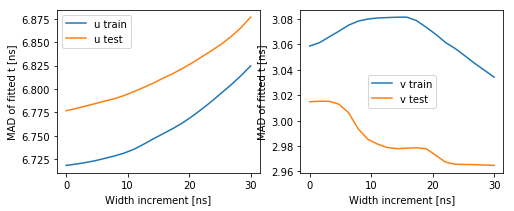

In [17]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = False, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].plot(dw_values, dt_train_values[i,:], label = side + ' train');
    ax[i].plot(dw_values, dt_test_values[i,:], label = side + ' test');
    ax[i].legend()
    ax[i].set_xlabel('Width increment [ns]')
    ax[i].set_ylabel('MAD of fitted t [ns]')
plt.savefig('MADt_vs_dw.png')